In [ ]:
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict

from scipy.special import digamma, polygamma, gammaln

from IPython.core.display import display, HTML
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords

In [ ]:
news_data = pd.read_csv("./bbc-news-data.csv", sep="\t")
news_data.head()

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


# Data Preprocessing
- stopwords, alphabet이 아닌 word 제거
- 길이가 3 이하인 단어 제거
- 빈도수가 낮은 word 제거 (제거 기준: 5개 이하)
- 소문자 변환
- `vocab_to_index`, `index_to_vocab` dictionary 정의
- text data를 index로 변환

In [ ]:
news_df = pd.DataFrame({'document': news_data["content"]})

# 특수 문자 제거
news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z]", " ", regex=True)

# 길이가 3 이하인 단어는 제거
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

# 전체 단어에 대한 소문자 변환
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())

# stopwords 제거
nltk.download('stopwords')
stop_words = stopwords.words('english')
tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split()) # 토큰화
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
data = []

for i in range(tokenized_doc.shape[0]): # document 개수
  doc = tokenized_doc[i]
  data.append(doc)

len(data)

2225

In [ ]:
# count word occurrence in corpus
def count_vocab(corpus):
    vocab = defaultdict(int)
    for doc in corpus:
        for word in doc:
            vocab[word] += 1

    return vocab

vocab_count = count_vocab(data)


# only consider valid words with occurrence > cnt
def vocab_top(vocab,cnt):
    temp = defaultdict(int)
    for voca, count in vocab.items():
        if count > cnt:
            temp[voca] = count

    return temp

vocab_count = vocab_top(vocab_count, cnt=5)


# filter out low-occurrence words
def filter_vocab(corpus,vocab):
    data = list()
    for doc in corpus:
        temp = list()
        for word in doc:
            if word in vocab.keys():
                temp.append(word)
        if temp:
            data.append(temp)

    return data

data = filter_vocab(data, vocab_count)

In [ ]:
docs = [' '.join(words) for words in data]
len(docs)

2225

In [ ]:
# construct voca-index-matching dictionary
def voca_index(vocab):
    vocab_to_index, index_to_vocab = dict(), dict()
    for i, voca in enumerate(vocab.keys()):
        vocab_to_index[voca] = i
        index_to_vocab[i] = voca

    return vocab_to_index, index_to_vocab

v_t_i, i_t_v = voca_index(vocab_count)


# convert corpus-with-words to corpus-with-index
def corpus_to_index(corpus,vocab_to_index):
    data = list()
    for doc in corpus:
        temp = list()
        for word in doc:
            temp.append(vocab_to_index[word])
        data.append(temp)

    return data

data_idx = corpus_to_index(data, v_t_i)

In [ ]:
# vocab to index
v_t_i

{'quarterly': 0,
 'profits': 1,
 'media': 2,
 'giant': 3,
 'timewarner': 4,
 'jumped': 5,
 'three': 6,
 'months': 7,
 'december': 8,
 'year': 9,
 'earlier': 10,
 'firm': 11,
 'biggest': 12,
 'investors': 13,
 'google': 14,
 'benefited': 15,
 'sales': 16,
 'high': 17,
 'speed': 18,
 'internet': 19,
 'connections': 20,
 'higher': 21,
 'advert': 22,
 'said': 23,
 'fourth': 24,
 'quarter': 25,
 'rose': 26,
 'gains': 27,
 'offset': 28,
 'profit': 29,
 'warner': 30,
 'bros': 31,
 'less': 32,
 'users': 33,
 'time': 34,
 'friday': 35,
 'owns': 36,
 'search': 37,
 'engine': 38,
 'business': 39,
 'mixed': 40,
 'fortunes': 41,
 'lost': 42,
 'subscribers': 43,
 'lower': 44,
 'quarters': 45,
 'however': 46,
 'company': 47,
 'underlying': 48,
 'exceptional': 49,
 'items': 50,
 'back': 51,
 'stronger': 52,
 'advertising': 53,
 'revenues': 54,
 'hopes': 55,
 'increase': 56,
 'offering': 57,
 'online': 58,
 'service': 59,
 'free': 60,
 'customers': 61,
 'sign': 62,
 'existing': 63,
 'broadband': 64,
 '

# LDA

![](https://velog.velcdn.com/images/kmeeziv/post/d9539464-84a0-4cd3-84d9-e5c40a96a557/image.png)

## **1) alpha**
- `alpha`: K-vector
- `alpha[i]`: i번째 topic에 대한 Dirichlet 파라미터
<br><br>

### [update 1]

$$ \alpha_{i+1} = \alpha_i - H^{-1}(\alpha_i)g(\alpha_i) $$
<br>

$$ g(\alpha_i) = \frac{\partial L}{\partial \alpha_i} = M\left( \psi\left(\sum_{j=1}^k \alpha_j\right) - \psi(\alpha_i) \right) + \sum_{d=1}^M \left( \psi(γ_{di}) - \psi\left(\sum_{j=1}^k γ_{dj}\right) \right) $$
<br>

$$ H(\alpha_i) = \frac{\partial^2 L}{\partial \alpha_i \alpha_j} = M \left( - \delta(i,j) \psi'(\alpha_i) + \psi'\left(\sum_{j=1}^k \alpha_j\right) \right) $$


---

### [update 2]

$$ \alpha_{i+1} = \alpha_i - (H^{-1}g)_i $$
<br>

$$ (H^{-1}g)_i = \frac{g_i-c}{h_i} $$
<br>

$$ c = \frac{\sum_{j=1}^K g_j / h_j}{z^{-1} + \sum_{j=1}^K h_j^{-1}} $$

## **2) beta**
- `beta`: K x V matrix, topic별 word의 분포
- `beta[i, v]`: topic이 i일때, v번째 word가 나타날 확률
<br><br>

### [init]
$$ \sum_{j=1}^V \beta_{ij} = 1 $$

<br>

### [update]
$$ \beta_{ij} \propto \sum_{d=1}^M \sum_{n=1}^N \phi_{dni} \mathbf{w}_{dn}^j $$

## **3) gamma**
- `gamma`: M x K matrix
- `gamma[m, i]`: m번째 document에서 i번째 topic에 대한 Dirichlet 파라미터
<br><br>

### [update]
$$ \gamma_i = \alpha_i + \sum_{n=1}^N \phi_{ni} $$

## **4) phi**
- `phi`: M x Nd x K array
- `phi[m][n][i]`: m번째 document의 n번째 word가 i번째 topic일 확률, Multinomial 파라미터
<br><br>

### [init]
$$ \sum_{i=1}^K \phi_{ni} = 1 $$

<br>

### [update]
$$ \phi_{ni} \propto \beta_{iv} exp \left(\psi(\gamma_i) - \psi(\sum_{j=1}^k \gamma_j)\right) $$

## **perplexity**

$$ perplexity(D) = exp \left( - \frac{ \sum_{d=1}^M logp(w_d)}{\sum_{d=1}^M N_d}  \right) $$
<br>

$$ logp(w_d) = L(\gamma, \phi; \alpha, \beta) + KL\left(q(\theta, z | \gamma, \phi) || p(\theta, z| w, \alpha, \beta) \right)$$
<br>

## **elbo**
$$ L(\gamma, \phi; \alpha, \beta) = \sum_{n=1}^N \sum_{i=1}^K \sum_{j=1}^V \phi_{ni} w_n^j log\beta_{ij} + \sum_{n=1}^N \sum_{i=1}^K \phi_{ni} \left(\psi(\gamma_i) - \psi(\sum_{i=1}^K) - log \phi_{ni}\right) + \sum_{i=1}^K (\alpha_i- \gamma_i)\left(\psi(\gamma_i) - \psi(\sum_{i=1}^K \gamma_i)\right) - \sum_{i=1}^K log\Gamma(\alpha_i) + \sum_{i=1}^K log\Gamma(\gamma_i) + logΓ(\sum_{i=1}^K \alpha_i) - log\Gamma(\sum_{i=1}^K \gamma_i) $$

In [ ]:
class LDA_VI:
    def __init__(self, docs, vocab, num_topic=10, num_iter=100):
        self.docs = docs # corpus: M개의 documents
        self.num_topic = num_topic # K: topic의 개수
        self.vocab = vocab # v_t_i / i_t_v
        self.num_vocab = len(self.vocab) # V: corpus에 존재하는 vocab의 개수
        self.num_docs = len(self.docs) # M: document의 개수

        self.alpha = np.ones(self.num_topic)*(1/self.num_topic) # K-vector

        self.beta = np.ones((self.num_topic,self.num_vocab))*(1/self.num_vocab) # K x V


        self.eps = 1e-12

        # beta random initialization
        for i in range(self.num_topic):
            for v in range(self.num_vocab):
                self.beta[i][v] += np.random.rand(1) * 0.01
            # 각 topic에 대해 beta normailize
            self.beta[i] /= np.sum(self.beta[i])

        self.gamma = np.ones((self.num_docs,self.num_topic))*(1/self.num_topic) # M x K

        self.phi = list() # M x Nd x K
        for doc in self.docs:
            temp = list()
            for word in doc:
                temp.append(np.ones(self.num_topic)*(1/self.num_topic))
            self.phi.append(temp)

        self.z = list() # M x Nd
        for doc in self.docs:
            temp = list()
            for word in doc:
                temp.append(None)
            self.z.append(temp)

        self.num_iter = num_iter # Variational EM 반복 횟수

        self.perps = [float("inf")] # iter별 perplexity


    def update_gamma(self, m): # m번째 document에 대해서 gamma update
        # gamma[m, i]: m번째 document에서 i번째 topic에 대한 Dirichlet 파라미터

        for i in range(self.num_topic):
            self.gamma[m, i] = self.alpha[i]
            for n in range(len(self.docs[m])):
                self.gamma[m, i] += self.phi[m][n][i]
        return None


    def update_phi(self, m): # m번째 document에 대해 phi update
        # phi[m, n, i]: m번째 document의 n번째 word가 i번째 topic일 확률

        for n in range(len(self.docs[m])):
            for i in range(self.num_topic):
                self.phi[m][n][i] = self.beta[i, self.docs[m][n]] * np.exp(digamma(self.gamma[m, i]) - digamma(np.sum(self.gamma[m]))) + 1e-10

            # 각 vocab에 대해 phi normailize
            self.phi[m][n] /= np.sum(self.phi[m][n])
        return None


    def update_beta(self): #corpus에 대해 beta update
        # beta[i, v]: topic이 i일때, v번째 word가 나타날 확률

        self.beta = np.zeros((self.num_topic,self.num_vocab)) #beta 초기화

        for m in range(self.num_docs):
            for n in range(len(self.docs[m])):
                for i in range(self.num_topic):
                    self.beta[i, self.docs[m][n]] += self.phi[m][n][i]

        # 각 topic에 대해 beta normailize
        for i in range(self.num_topic):
            self.beta[i] += 1e-10
            self.beta[i] /= np.sum(self.beta[i])
        return None


    def update_alpha(self): # corpus에 대해 alpha update
        # alpha[i]: i번째 topic에 대한 Dirichlet 파라미터

        # compute g
        g = np.zeros(self.num_topic) # elbo의 1차 미분

        for i in range(self.num_topic):
            g[i] = self.num_docs * ( digamma(np.sum(self.alpha)) - digamma(self.alpha[i]) )
            for m in range(self.num_docs):
                g[i] += ( digamma(self.gamma[m, i]) - digamma(np.sum(self.gamma[m])) )

        # compute H
        H = np.zeros((self.num_topic, self.num_topic)) # elbo의 2차 미분

        for i in range(self.num_topic):
            for j in range(self.num_topic):
                if i == j:
                    H[i, j] = -self.num_docs * polygamma(1, self.alpha[i]) + self.num_docs * polygamma(1, np.sum(self.alpha))
                else:
                    H[i, j] = self.num_docs * polygamma(1, np.sum(self.alpha))

        self.alpha -= np.linalg.inv(H) @ g
        return None

    def update_alpha_linear_time(self):
        # compute g
        g = np.zeros(self.num_topic)

        for i in range(self.num_topic):
            g[i] = self.num_docs * (digamma(self.alpha.sum()) - digamma(self.alpha[i]))
            for m in range(self.num_docs):
                g[i] += (digamma(self.gamma[m, i]) - digamma(self.gamma[m].sum()))

        # compute h
        h = np.zeros(self.num_topic)
        for i in range(self.num_topic):
            h[i] =  -self.num_docs * polygamma(1,self.alpha[i])

        z = self.num_docs * polygamma(1, self.alpha.sum())

        c = (g/h).sum()/ (1/z + (1/h).sum())

        self.alpha -= ((g-c) / h)
        return None


    def e_step(self):
        # document별 phi, gamma update
        for m in range(self.num_docs):
            self.update_phi(m)
            self.update_gamma(m)
        return None


    def m_step(self):
        self.update_beta() # beta update

        # alpha update
        for iter in range(5):
            self.update_alpha_linear_time()
        return None


    def compute_elbo(self, m):
        elbo = 0

        for i in range(self.num_topic):
            for n in range(len(self.docs[m])):
                elbo += ( self.phi[m][n][i] * (np.log(self.beta[i, self.docs[m][n]])
                                                + (digamma(self.gamma[m, i]) - digamma(np.sum(self.gamma[m])))
                                                - np.log(self.phi[m][n][i])) )

            elbo += ( (self.alpha[i] - self.gamma[m, i]) * (digamma(self.gamma[m, i]) - digamma(np.sum(self.gamma[m])))
                    - gammaln(self.alpha[i])
                    + gammaln(self.gamma[m, i]))

        elbo += ( gammaln(np.sum(self.alpha)) - gammaln(np.sum(self.gamma[m])))
        return elbo


    def compute_perplexity(self,):
        total_elbo = 0
        total_N = 0

        for m in range(self.num_docs):
            total_elbo += self.compute_elbo(m)
            total_N += len(self.docs[m])

        perplexity = np.exp(-total_elbo / total_N)
        return perplexity


    def compute_z(self):
        # z[m][n]: m번째 document에서 n번째 word의 topic

        for m in range(self.num_docs):
            for n in range(len(self.docs[m])):
                self.z[m][n] = np.random.multinomial(1, self.phi[m][n]).argmax().item()
        return None


    def run(self,):
        cnt = 0

        for iter in range(self.num_iter):
            # variational EM
            self.e_step()
            self.m_step()

            perplexity = self.compute_perplexity()
            self.perps.append(perplexity)
            print(f"\n[#{iter+1}] perplexity: {perplexity:.5f}")

            # 종료 조건
            if (self.perps[-2] - self.perps[-1]) < 1:
                cnt += 1

            if cnt > 5:
                break

        self.compute_z()
        return None

In [ ]:
## run LDA
LDA = LDA_VI(data_idx, v_t_i, num_topic=5, num_iter=100)
LDA.run()

/tmp/ipykernel_3564978/4204191097.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.beta[i][v] += np.random.rand(1) * 0.01



[#1] perplexity: 3375.30773

[#2] perplexity: 3332.02760

[#3] perplexity: 3318.17317

[#4] perplexity: 3311.93917

[#5] perplexity: 3307.20405

[#6] perplexity: 3303.21792

[#7] perplexity: 3299.35717

[#8] perplexity: 3294.98662

[#9] perplexity: 3289.25731

[#10] perplexity: 3280.79923

[#11] perplexity: 3267.22461

[#12] perplexity: 3244.45351

[#13] perplexity: 3206.32170

[#14] perplexity: 3145.73367

[#15] perplexity: 3058.56472

[#16] perplexity: 2948.90041

[#17] perplexity: 2829.62150

[#18] perplexity: 2714.97675

[#19] perplexity: 2613.64476

[#20] perplexity: 2528.25032

[#21] perplexity: 2458.10146

[#22] perplexity: 2401.38968

[#23] perplexity: 2355.79003

[#24] perplexity: 2319.02428

[#25] perplexity: 2289.42241

[#26] perplexity: 2265.47872

[#27] perplexity: 2245.91855

[#28] perplexity: 2229.85465

[#29] perplexity: 2216.39273

[#30] perplexity: 2205.03482

[#31] perplexity: 2195.44025

[#32] perplexity: 2187.07646

[#33] perplexity: 2179.74053

[#34] perplexity: 

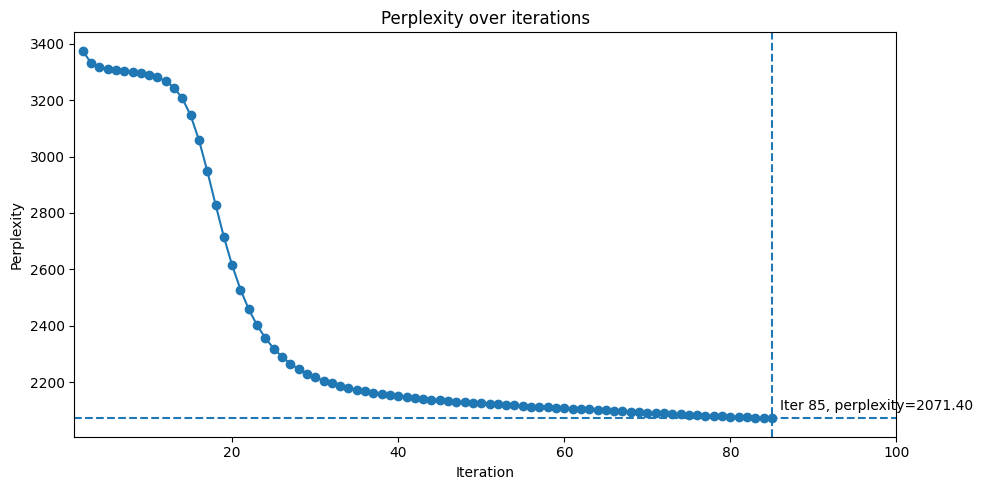

In [ ]:
iterations = list(range(1, len(LDA.perps) + 1))

target_iters = 100

plt.figure(figsize=(10, 5))
plt.plot(iterations, LDA.perps, marker='o')
plt.xlim(1, target_iters)

# Early-Stopping
last_iter = iterations[-1]
last_ppx = LDA.perps[-1]
plt.axvline(last_iter, linestyle='--')
plt.axhline(last_ppx, linestyle='--')
plt.text(last_iter + 1, last_ppx + 30, f'Iter {last_iter}, perplexity={last_ppx:.2f}')

plt.xlabel("Iteration")
plt.ylabel("Perplexity")
plt.title("Perplexity over iterations")
plt.tight_layout()

plt.show()


In [ ]:
# 모델 저장
with open("LDA_model.pkl", "wb") as f:
    pickle.dump(LDA, f)

In [ ]:
# 모델 불러오기
with open("LDA_model.pkl", "rb") as f:
    LDA = pickle.load(f)

# 확인
print(LDA.alpha)
print(LDA.beta.shape)

[0.04734795 0.04279643 0.06338374 0.06035623 0.05132568]
(5, 8664)


# Analyze Results

In [ ]:
topic_colors = [
    '#D45584',
    '#F4A261',
    '#7BC27F',
    '#5FA8D3',
    '#8E62C9'
]


def topic_word(model, topic, num_words=10): # 각 topic별 나올 확률이 높은 num_words개의 words
    words = [i_t_v[index] for index in model.beta[topic].argsort()[::-1][:num_words]]
    return words

# topic-word proportion visualization
def topic_word_proportion(model):
    html_content = ""
    for i in range(model.num_topic):
        words = topic_word(model, i)
        color = topic_colors[i % len(topic_colors)]
        topic_header = f'<span style="color:{color}; font-size: 20px; font-weight:bold">TOPIC {i + 1:02}</span>: '
        words_html = ' '.join([f'<span style="font-size: 20px;">{word},</span>' for word in words])
        html_content += f'{topic_header}{words_html}<br><br>'
    return html_content


# document visualization
def document_visualizaion(model, original_docs, idx, doc_nums):
    html_content = ""
    for i, topic_assignment in enumerate(model.z[idx:idx+doc_nums]):
        html_content += f"<span style='font-size:20px; font-weight:bold;'>[DOC {i+idx+1 :04}] </span>"
        for j, original_word in enumerate(original_docs[i+idx]):
            try:
                word_idx = v_t_i[original_word]
                topic = topic_assignment[j]
                color = topic_colors[topic]
            except:
                color = ''
            html_content += f'<span style="color:{color}; font-size:20px;">{original_word}</span> '
        html_content += f"<br><br>"
    return html_content

## 1) Topic - Word

In [ ]:
topic_word_proportion_html = topic_word_proportion(LDA)
display(HTML(f"<html><body>{topic_word_proportion_html}</body></html>"))

## 2) Document - Topic

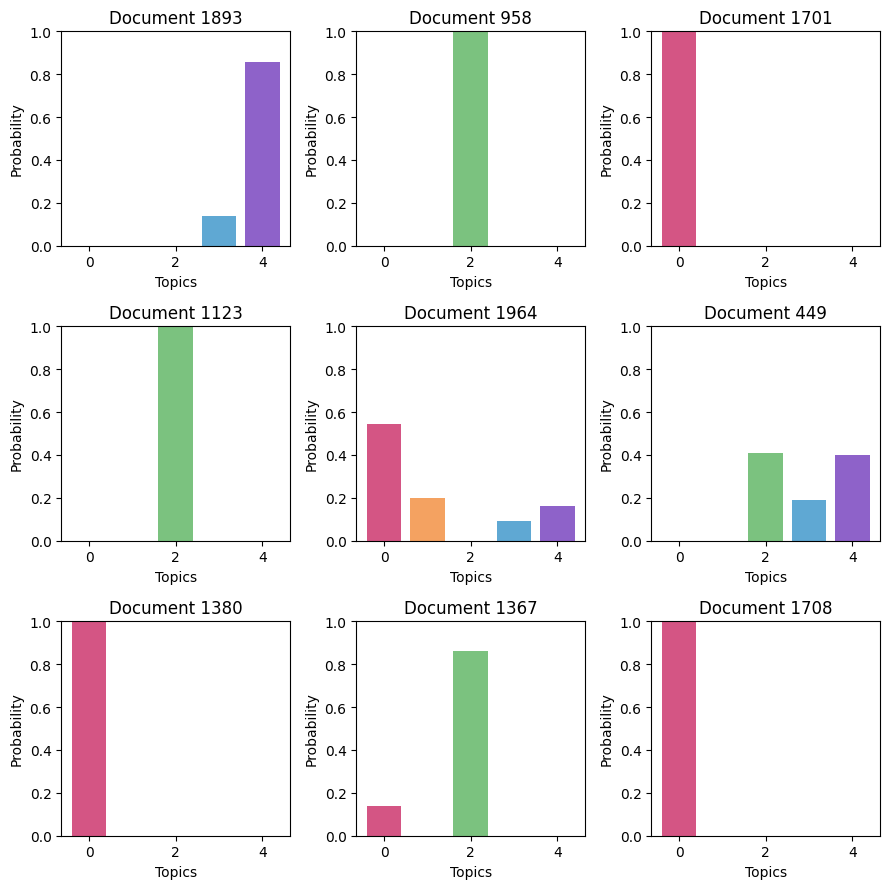

In [ ]:
theta_values = [np.random.dirichlet(gamma) for gamma in LDA.gamma]
doc_list = np.random.randint(0, len(data), 9)

fig, axs = plt.subplots(3, 3, figsize=(9, 9))

for m, theta in enumerate([theta_values[i] for i in doc_list]):
    row = m // 3
    col = m % 3
    axs[row, col].bar(range(len(theta)), theta, color=[topic_colors[j % len(topic_colors)] for j in range(len(theta))])
    axs[row, col].set_title(f'Document {doc_list[m]+1}')
    axs[row, col].set_xlabel('Topics')
    axs[row, col].set_ylabel('Probability')
    axs[row, col].set_ylim(0, 1)

plt.tight_layout()
plt.show()

## 3) Document Visualization

In [ ]:
doc_list = [156, 800, 1059, 1500, 2000]

for doc in doc_list:
    doc_html = document_visualizaion(LDA, data, doc-1, 1)
    display(HTML(f"<html><body>{doc_html}</body></html>"))

# Evaluation Metrics
- Accuracy
- ARI (Adjusted Rand Index)
- NMI (Normalized Mutual Information)

In [ ]:
pred_topic = np.argmax(theta_values, axis=-1)
true_topic = news_data['category']

count_matrix = pd.crosstab(pred_topic, true_topic)
count_matrix

category,business,entertainment,politics,sport,tech
row_0,,,,,
0,0,0,1,481,8
1,3,359,2,1,14
2,41,15,410,28,8
3,393,7,2,1,57
4,73,5,2,0,314


In [ ]:
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score


# Assignment pseudo-label
cost = - count_matrix.values

# Hungarian Algorithm
row_ind, col_ind = linear_sum_assignment(cost)

# mapping: pred_topic(row) → true_topic(col)
mapping = {int(row): count_matrix.columns[int(col)] for row, col in zip(row_ind, col_ind)}
mapped_pred_topic = np.array([mapping[p] for p in pred_topic])

# accuracy
accuracy = np.mean(mapped_pred_topic == true_topic)
print(f"Accuracy: {accuracy:.3f}")


# ARI
ari = adjusted_rand_score(true_topic, mapped_pred_topic)
print(f"ARI Score: {ari:.3f}")


# NMI
nmi = normalized_mutual_info_score(true_topic, mapped_pred_topic)
print(f"NMI Score: {nmi:.3f}")

Accuracy: 0.880
ARI Score: 0.736
NMI Score: 0.733


# Text Generation

In [ ]:
# generate text
def text_generation(mapping, text_num=10):
    html_content = ""
    for i in range(text_num):
        html_content += f"<span style='font-size:20px; font-weight:bold; color:gray;'>[Example {i+1 :02}] </span>"
        phi = np.random.dirichlet(LDA.alpha)
        num_words = np.random.randint(15, 20, 1).item()

        for _ in range(num_words):
            topic = np.argmax(np.random.multinomial(1,phi,1))
            word_idx = np.argmax(np.random.multinomial(1,LDA.beta[topic],1))
            gen_word = i_t_v[word_idx]
            color = topic_colors[topic]
            html_content += f'<span style="color:{color}; font-size:20px;">{gen_word}</span> '
        html_content += f"<br><br>"
    return html_content

In [ ]:
text = text_generation(mapping, text_num=10)
display(HTML(f"<html><body>{text}</body></html>"))